### Analysis of Nanopore direct-RNA sequencing results

This notebook aims to analyse Nanopore direct-RNA sequencing results for in vitro transcribed RNAs. Anh has sequenced two samples using flongles (RNA002 pore) and named them as sample_B (control) and sample_C (a mix of U and 4SU). It would be interesting to compare the results for the two samples, especially their quality scores.

We will download the latest version of [dorado](https://github.com/nanoporetech/dorado).

```
cd src

wget https://cdn.oxfordnanoportal.com/software/analysis/dorado-0.4.2-linux-x64.tar.gz

.tar.gz is a compressed file. To install dorado we need to decompress the tar ball.

```
tar zxvf dorado-0.4.2-linux-x64.tar.gz

To call dorado from any directories, we will export the path of the dorado binary directory to the environment.

```
export PATH="/home/limch05p/lim_group/bioinfo_lessons/src/dorado-0.4.2-linux-x64/bin/:$PATH"

We can also add this line to ~/.bashrc so that we don't have to repeat this next time. We only have to run

```
source ~/.bashrc

We will download the RNA002 pore model. Let's make a new directory for storing the model.

```
cd dorado-0.4.2-linux-x64/
mkdir models
cd models
dorado download --model rna002_70bps_hac@v3

Let's change our directory back and do basecalling. Since Anh used Q score of 7 as the cutoff during sequencing, reads above Q score of 7 will be saved in fast5_pass

```
cd /home/limch05p/lim_group/bioinfo_lessons/

dorado basecaller \
../src/dorado/models/rna002_70bps_hac\@v3 \
../doc/20230908_Anh/sample_B/20230908_1555_X4_AQA286_526a7755/fast5_pass/ \
> ../doc/20230908_Anh/sample_B/20230908_1555_X4_AQA286_526a7755/sample_B_pass_aligned.bam

dorado basecaller \
../src/dorado/models/rna002_70bps_hac\@v3 \
../doc/20230908_Anh/sample_C/20230908_1609_X5_APY909_301db406/fast5_pass/ \
> ../doc/20230908_Anh/sample_C/20230908_1609_X5_APY909_301db406/sample_C_pass_aligned.bam

We will get primary aligned reads from the BAM file. We can figure out the appropriate SAM flags [here](https://broadinstitute.github.io/picard/explain-flags.html). A bitwise flag is 2308 means not primary alignment, read unmapped and supplementary alignment. To remove these reads, we will use the samtools view -F (--exclude-flags) argument.

```
samtools view -F 2308 -b ../doc/20230908_Anh/sample_B/20230908_1555_X4_AQA286_526a7755/sample_B_pass_aligned_polyA.bam \
| samtools sort > ../doc/primary_sample_B_pass_aligned_polyA.bam

samtools view -F 2308 -b ../doc/20230908_Anh/sample_C/20230908_1609_X5_APY909_301db406/sample_C_pass_aligned_polyA.bam \
| samtools sort > ../doc/primary_sample_C_pass_aligned_polyA.bam

Now, let's analyse the BAM files. We will install pingouin for this analysis.

```
conda install -c conda-forge pingouin -y

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt

Nanopore sequencing results have multiple different formats, including Fast5 (deprecated), POD5 and [FASTQ](https://en.wikipedia.org/wiki/FASTQ_format). FASTQ files store both sequences and quality scores (Q score). More recently Nanopore introduces [duplex](https://github.com/nanoporetech/duplex-tools#usage-with-dorado-recommended) read basecalling using a quality value ranging from 0 to 50.

We will make a dictionary of Q scores for later use.

In [2]:
qscore = {
    "!": 0,
    '"': 1,
    "#": 2,
    "$": 3,
    "%": 4,
    "&": 5,
    "'": 6,
    "(": 7,
    ")": 8,
    "*": 9,
    "+": 10,
    ",": 11,
    "-": 12,
    ".": 13,
    "/": 14,
    "0": 15,
    "1": 16,
    "2": 17,
    "3": 18,
    "4": 19,
    "5": 20,
    "6": 21,
    "7": 22,
    "8": 23,
    "9": 24,
    ":": 25,
    ";": 26,
    "<": 27,
    "=": 28,
    ">": 29,
    "?": 30,
    "@": 31,
    "A": 32,
    "B": 33,
    "C": 34,
    "D": 35,
    "E": 36,
    "F": 37,
    "G": 38,
    "H": 39,
    "I": 40,
    "J": 41,
    "K": 42,
    "L": 43,
    "M": 44,
    "N": 45,
    "O": 46,
    "P": 47,
    "Q": 48,
    "R": 49,
    "S": 50,
}

Since Nanopore sequencing results have high error rates, we will run samtools mpileup to analyse how well the alignment results are.

```
samtools mpileup ../doc/primary_sample_B_pass_aligned_polyA.bam > ../doc/primary_sample_B_pass_aligned_polyA.mpileup

samtools mpileup ../doc/primary_sample_C_pass_aligned_polyA.bam > ../doc/primary_sample_C_pass_aligned_polyA.mpileup

In [3]:
ref = pd.read_csv('../ref/ref_polyA.fa', sep='>', lineterminator='>', header=None)
ref['seq'] = ref[0].str.split('\n').apply(lambda x: x[1].upper())
ref = pd.DataFrame([*ref.seq[0]])
ref.reset_index(inplace=True)
ref.columns = ['position','reference base']
ref['pos'] = ref['position'] + 1

# We will encode bases as integers. You will see how I use them later on.
bases = {'A':0,'C':1,'G':2,'U':3}
ref['ref'] = ref['reference base'].apply(lambda x: bases[x])

Let's make use of the qscore dictionary above to calculate the mean Q score per position.

In [4]:
bpile = pd.read_csv('../doc/primary_sample_B_pass_aligned_polyA_sorted_plus.mpileup', sep='\t', header=None)
bpile['encoded qscores'] = bpile[5].apply(lambda x: [*x])
bpile['qscores'] = bpile['encoded qscores'].apply(lambda x: [qscore[i] for i in x])
bpile['mean qscore'] = bpile['encoded qscores'].apply(lambda x: np.mean([qscore[i] for i in x]))
bpile['sample'] = 'U'

In [5]:
# bpile['position'] = bpile[1] - 1
# bpile = pd.merge(bpile, ref, on='position')
# bpile['reference base'] = bpile['reference base'].str.replace('U','T')
# bpile['bases'] = bpile[4].str.replace(r'\^.','', regex=True)
# bpile['bases'] = bpile['bases'].str.replace('$','', regex=False)
# bpile['bases'] = bpile['bases'].apply(lambda x: x.upper())
# bpile['base depth'] = bpile['bases'].apply(lambda x: len(x))
# bpile['ref vs bases'] = bpile[['reference base','bases']].values.tolist()
# bpile['errors'] = bpile['ref vs bases'].apply(lambda x: x[1].replace(x[0],''))

# bpile['indels'] = bpile.errors.str.replace(r'[A-Z]','', regex=True)
# bpile['indels'] = bpile.indels.str.split(r'([+-][0-9]+)', regex=True)

# #https://stackoverflow.com/a/2859738
# def convert(val):
#     constructors = [int, str]
#     for c in constructors:
#         try:
#             return c(val)
#         except ValueError:
#             pass

# bpile['indels'] = bpile.indels.apply(lambda x: [convert(i) for i in x if i])

# bpile['insertions'] = bpile.indels.apply(lambda x: np.sum([i for i in x if (isinstance(i, int)==True and i>0)]))
# bpile['deletions'] = bpile.indels.apply(lambda x: np.sum([i for i in x if (isinstance(i, int)==True and i<0)]))
# bpile['mismatched'] = bpile.errors.str.replace(r'[+-][0-9]+','', regex=True)
# bpile['mismatched len'] = bpile['mismatched'].apply(lambda x: len(x))
# bpile['mismatches'] =  bpile['mismatched len'] - bpile['insertions'] + bpile['deletions']

We will use Base_Counter from allelecount to parse the mpileup files.

In [5]:
# https://github.com/photonchang/allelecount/blob/master/allelecount.py

import sys

# Base Counting Subroutine *[Completed]
def Base_Counter(InputRow):
	InputList = []
	InputList = InputRow.split(sep = '\t')
	
	# Cleaning up Base String + Indel Counting
	CleanString = ''
	countIn = 0
	countDel = 0
	IndelHolder = []
	IndelDeterminant = 0
	CleanBool = False
	
	for currentIndex, Strholder in enumerate(InputList[4]):
		# Skipping of '^' Signage
		if CleanBool == True:
			CleanBool = False
			continue
		
		if Strholder == '^':
			CleanBool = True
			continue
		
		# Skipping Indel
		if IndelDeterminant > 0:
			IndelDeterminant -= 1
			continue
		
		if Strholder == '+':
			countIn += 1
			
			# Determining Length of Indel
			# Since Illumina NGS has an upper limit of less than 999bp read length
			IndelDeterminant = 0
			
			if (currentIndex + 4) <= len(InputList[4]):
				if InputList[4][currentIndex + 1: currentIndex + 4].isnumeric() == True:
					IndelDeterminant = int(InputList[4][currentIndex + 1: currentIndex + 4]) + 3
				elif InputList[4][currentIndex + 1: currentIndex + 3]. isnumeric() == True:
					IndelDeterminant = int(InputList[4][currentIndex + 1: currentIndex + 3]) + 2
				elif InputList[4][currentIndex + 1: currentIndex + 2].isnumeric() == True:
					IndelDeterminant = int(InputList[4][currentIndex + 1: currentIndex + 2]) + 1
			elif (currentIndex + 3) <= len(InputList[4]):
				if InputList[4][currentIndex + 1: currentIndex + 3]. isnumeric() == True:
					IndelDeterminant = int(InputList[4][currentIndex + 1: currentIndex + 3]) + 2
				elif InputList[4][currentIndex + 1: currentIndex + 2].isnumeric() == True:
					IndelDeterminant = int(InputList[4][currentIndex + 1: currentIndex + 2]) + 1
			
			IndelHolder.append(InputList[4][currentIndex:currentIndex + IndelDeterminant + 1])
			continue
		
		if Strholder == '-':
			countDel += 1
			
			# Determining Length of Indel
			# Since Illumina NGS has an upper limit of less than 999bp read length
			IndelDeterminant = 0
			
			if (currentIndex + 4) <= len(InputList[4]):
				if InputList[4][currentIndex + 1: currentIndex + 4].isnumeric() == True:
					IndelDeterminant = int(InputList[4][currentIndex + 1: currentIndex + 4]) + 3
				elif InputList[4][currentIndex + 1: currentIndex + 3]. isnumeric() == True:
					IndelDeterminant = int(InputList[4][currentIndex + 1: currentIndex + 3]) + 2
				elif InputList[4][currentIndex + 1: currentIndex + 2].isnumeric() == True:
					IndelDeterminant = int(InputList[4][currentIndex + 1: currentIndex + 2]) + 1
			elif (currentIndex + 3) <= len(InputList[4]):
				if InputList[4][currentIndex + 1: currentIndex + 3]. isnumeric() == True:
					IndelDeterminant = int(InputList[4][currentIndex + 1: currentIndex + 3]) + 2
				elif InputList[4][currentIndex + 1: currentIndex + 2].isnumeric() == True:
					IndelDeterminant = int(InputList[4][currentIndex + 1: currentIndex + 2]) + 1
			
			IndelHolder.append(InputList[4][currentIndex: currentIndex + len(str(IndelDeterminant)) + 1])
			continue
		
		CleanString += Strholder
	
	else:
	# Transferring Back Cleaned String
		InputList[4] = CleanString
		
		# '$' Signage Stripping
		InputList[4] = InputList[4].replace('$', '')
		
	# Base Count Var Initialization
	bigA = 0
	bigC = 0
	bigG = 0
	bigT = 0
	smallA = 0
	smallC = 0
	smallG = 0
	smallT = 0
	delBase = 0
	
	# Base Counting
	bigA = InputList[4].count('A')
	bigC = InputList[4].count('C')
	bigG = InputList[4].count('G')
	bigT = InputList[4].count('T')
	bigN = InputList[4].count('N')
	
	smallA = InputList[4].count('a')
	smallC = InputList[4].count('c')
	smallG = InputList[4].count('g')
	smallT = InputList[4].count('t')
	smallN = InputList[4].count('n')
	
	delBase = InputList[4].count('*')
	
	# Internal Check - Throws Out Error (NOT STD-IN/OUT Compatible: Should break pipeline)
	InternalCounter = 0
	InternalCounter = bigA + bigC + bigG + bigT + bigN + smallA + smallC + smallG + smallT + smallN + delBase
	if InternalCounter != int(InputList[3]):
		print('Error at position: ' + InputList[1])
		print('Reported count: ' + InputList[3])
		print('Internal counter: ' + str(InternalCounter))
		print('Internal sum: ' + str(len(InputList[4])))
		print('Number of insertions: ' + str(countIn))
		print('Number of deleions: ' + str(countDel))
		print('Post-processed bases: ' + InputList[4])
# 		sys.exit()
	
	# Indel Compilation
	IndelSetDict = set(IndelHolder)
	tmpIndelString = ''
	FinalIndelHolder = []
	
	for EveryIndel in IndelSetDict:
		tmpIndelString = ''
		tmpIndelString = str(IndelHolder.count(EveryIndel)) + ":" + EveryIndel
		FinalIndelHolder.append(tmpIndelString)
	
	# Return Output
	FinalOutput = InputList[0] + '	' + InputList[1] + '	' + str(bigA) + '	' + str(bigC) + '	' + str(bigG) + '	' + str(bigT) + '	' + str(bigN) + '	' + str(smallA) + '	' + str(smallC) + '	' + str(smallG) + '	' + str(smallT) + '	' + str(smallN) + '	' + str(countIn) + '	' + str(countDel) + '	' + ';'.join(FinalIndelHolder)
	
	return FinalOutput

# # ----------------------------------------------------------------------------------------------------
# # Running Caller
# StreamCollector = ''
# for EveryChar in sys.stdin.read():
# 	if EveryChar == '\n':
# 		print(Base_Counter(StreamCollector))
# 		StreamCollector = ''
# 	else:
# 		StreamCollector += EveryChar

We will parse mpileup text file using StringIO and pandas. We will use a prefix of b and c to represent sample_B (control) and sample_C (a mixed of U and 4SU), respectively.

In [7]:
from io import StringIO

f = open("../doc/primary_sample_B_pass_aligned_polyA_sorted_plus.mpileup", "r")
bp = []

for k,v in enumerate(f):
    try:
        l = pd.read_csv(StringIO(Base_Counter(v)), sep='\t', header=None)
        bp.append(l)
#         print(k, end='\r')
    except:
        pass
f.close() 

bp = pd.concat(bp)
bp.columns = ['chr','pos','A','C','G','T','N','a','c','g','t','n','IN','DEL','indel']

Error at position: 1221
Reported count: 0
Internal counter: 1
Internal sum: 1
Number of insertions: 0
Number of deleions: 0
Post-processed bases: *


In [8]:
bp

,chr,pos,A,C,G,T,N,a,c,g,t,n,IN,DEL,indel
0,ref_polyA,1,12,0,0,0,0,0,0,0,0,0,0,0,NaN
0,ref_polyA,2,0,12,0,0,0,0,0,0,0,0,0,0,NaN
0,ref_polyA,3,12,0,0,0,0,0,0,0,0,0,0,0,NaN
0,ref_polyA,4,0,0,0,12,0,0,0,0,0,0,0,0,NaN
0,ref_polyA,5,0,0,0,18,0,0,0,0,0,0,1,0,1:+1C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ref_polyA,1217,13,0,0,0,0,0,0,0,0,0,0,0,NaN
0,ref_polyA,1218,3,0,0,0,0,0,0,0,0,0,0,0,NaN
0,ref_polyA,1219,2,0,0,0,0,0,0,0,0,0,0,0,NaN
0,ref_polyA,1220,1,0,0,0,0,0,0,0,0,0,0,0,NaN


This gives us an overview of the alignment results. For example, there are 113710 deletions in the alignment.

In [24]:
bp.sum()

/Volumes/scratch/gardnerlab/cslim/tmp/ipykernel_128959/2237009953.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bp.sum()


chr    ref_polyAref_polyAref_polyAref_polyAref_polyAr...
pos                                               746031
A                                                2003810
C                                                2097320
G                                                2111112
T                                                1201848
N                                                      0
a                                                      0
c                                                      0
g                                                      0
t                                                      0
n                                                      0
IN                                                 94397
DEL                                               113710
dtype: object

Let's calculate the number of mismatches.

In [9]:
bp = pd.merge(ref,bp)
bp

,position,reference base,pos,ref,chr,A,C,G,T,N,a,c,g,t,n,IN,DEL,indel
0,0,A,1,0,ref_polyA,12,0,0,0,0,0,0,0,0,0,0,0,NaN
1,1,C,2,1,ref_polyA,0,12,0,0,0,0,0,0,0,0,0,0,NaN
2,2,A,3,0,ref_polyA,12,0,0,0,0,0,0,0,0,0,0,0,NaN
3,3,U,4,3,ref_polyA,0,0,0,12,0,0,0,0,0,0,0,0,NaN
4,4,U,5,3,ref_polyA,0,0,0,18,0,0,0,0,0,0,1,0,1:+1C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,1216,A,1217,0,ref_polyA,13,0,0,0,0,0,0,0,0,0,0,0,NaN
1217,1217,A,1218,0,ref_polyA,3,0,0,0,0,0,0,0,0,0,0,0,NaN
1218,1218,A,1219,0,ref_polyA,2,0,0,0,0,0,0,0,0,0,0,0,NaN
1219,1219,A,1220,0,ref_polyA,1,0,0,0,0,0,0,0,0,0,0,0,NaN


We will create a set of four bases {0,1,2,3} per position and delete the reference base from there to create a list of mismatched bases (nonref).

In [10]:
bp['nonref'] = bp.ref.apply(lambda x: list({0,1,2,3} - set([x])))

We will make the list of counts by bases. Let's call that "mismatches" for now because we will overwrite it later on with the actually counts of mismatces.

In [11]:
bp['mismatches'] = bp[['A','C','G','T']].values.tolist()

We will then combine the mismatched bases (nonref) with the list of counts by bases (mismatchees).

In [12]:
bp['mismatches'] = bp[['nonref','mismatches']].values.tolist()

We will then use list comprehension to get the mismatches.

In [13]:
bp['mismatches'] = bp['mismatches'].apply(lambda x: np.sum([x[1][i] for i in x[0]]))

We will merge the mpile dataframe (bpile) with the new dataframe we created (bp). Remember that we have calculated average Q score per position using the original mpileup file.

In [14]:
bpile = bpile[['sample',0,1,3,'qscores','mean qscore']]
bpile.columns = ['sample','chr','pos','depth','qscores','mean qscore']
bp = pd.merge(bpile, bp[['chr','pos','reference base','IN','DEL','mismatches']])

We will calculate the fractions of indels and mismatches before plotting.

In [15]:
bp['IN frac'] = bp.IN/bp.depth
bp['DEL frac'] = bp.DEL/bp.depth
bp['mismatch frac'] = bp.mismatches/bp.depth

Interestingly, deletions appear more frequently around the first half of the sequence.

<Axes: xlabel='pos', ylabel='IN frac'>

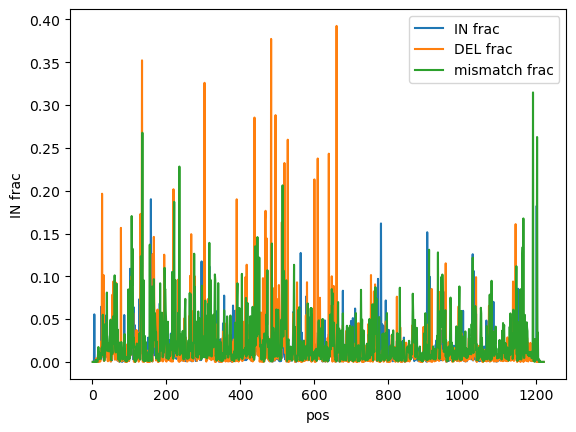

In [16]:
sns.lineplot(data=bp, x='pos', y='IN frac', label='IN frac')
sns.lineplot(data=bp, x='pos', y='DEL frac', label='DEL frac')
sns.lineplot(data=bp, x='pos', y='mismatch frac', label='mismatch frac')

In [17]:
bp.sort_values('DEL frac')

,sample,chr,pos,depth,qscores,mean qscore,reference base,IN,DEL,mismatches,IN frac,DEL frac,mismatch frac
0,U,ref_polyA,1,12,"[40, 28, 32, 29, 25, 18, 41, 34, 33, 24, 50, 27]",31.750000,A,0,0,0,0.000000,0.000000,0.000000
891,U,ref_polyA,892,7547,"[40, 44, 44, 30, 34, 45, 35, 40, 49, 31, 50, 4...",37.139261,A,23,0,82,0.003048,0.000000,0.010865
889,U,ref_polyA,890,7749,"[33, 41, 47, 40, 39, 40, 39, 47, 46, 39, 50, 2...",36.979223,C,8,0,9,0.001032,0.000000,0.001161
887,U,ref_polyA,888,7836,"[38, 49, 50, 46, 45, 33, 34, 49, 50, 50, 50, 2...",38.472052,G,7,0,17,0.000893,0.000000,0.002169
833,U,ref_polyA,834,7613,"[32, 33, 31, 48, 50, 50, 42, 40, 37, 37, 35, 4...",39.542887,A,44,0,176,0.005780,0.000000,0.023118
...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,U,ref_polyA,303,4233,"[23, 26, 22, 31, 33, 33, 25, 50, 17, 36, 13, 2...",23.613277,C,102,1380,23,0.024096,0.326010,0.005433
133,U,ref_polyA,134,5181,"[17, 14, 16, 39, 39, 13, 18, 23, 14, 14, 16, 2...",27.548736,U,103,1825,579,0.019880,0.352249,0.111754
482,U,ref_polyA,483,6009,"[15, 20, 16, 28, 28, 41, 30, 21, 16, 22, 25, 1...",28.800133,C,6,2267,3,0.000999,0.377267,0.000499
659,U,ref_polyA,660,4385,"[14, 13, 19, 38, 13, 27, 44, 16, 18, 44, 31, 3...",24.663626,C,46,1721,3,0.010490,0.392474,0.000684


It is also interesting to see that insertions and deletions occur more frequently at U.

<Axes: xlabel='reference base', ylabel='IN frac'>

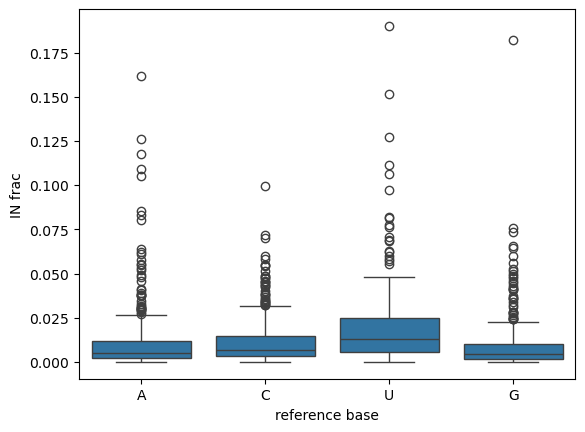

In [18]:
sns.boxplot(data=bp, y='IN frac', x='reference base')

<Axes: xlabel='reference base', ylabel='DEL frac'>

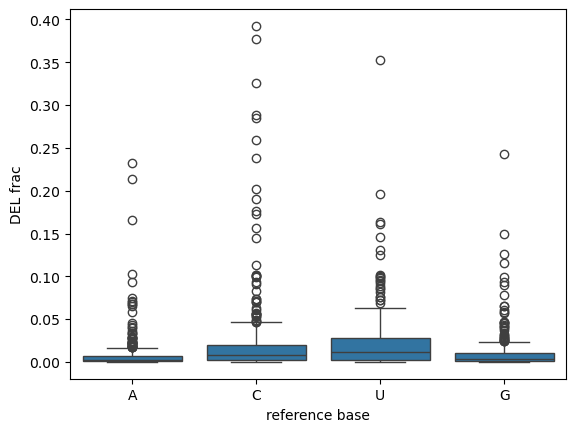

In [19]:
sns.boxplot(data=bp, y='DEL frac', x='reference base')

And mismatches occur more frequently at both A and U.

<Axes: xlabel='reference base', ylabel='mismatch frac'>

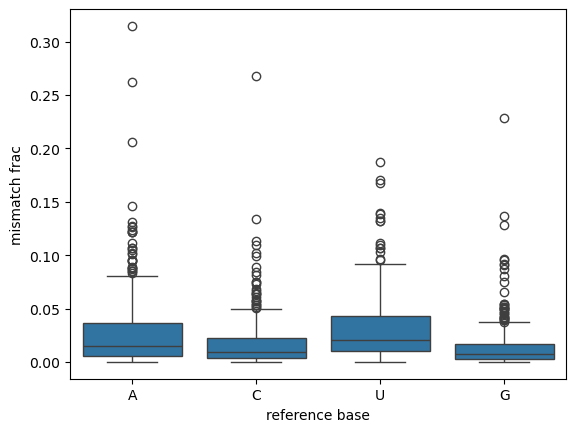

In [20]:
sns.boxplot(data=bp, y='mismatch frac', x='reference base')

Let's compare in vitro transcribed RNAs with sample_B and (sample_C).

In [4]:
cpile = pd.read_csv('primary_sample_C_pass_aligned_polyA_sorted.mpileup', sep='\t', header=None)
cpile['encoded qscores'] = cpile[5].apply(lambda x: [*x])
cpile['qscores'] = cpile['encoded qscores'].apply(lambda x: [qscore[i] for i in x])
cpile['mean qscore'] = cpile['encoded qscores'].apply(lambda x: np.mean([qscore[i] for i in x]))
cpile['sample'] = 'U+4SU'

In [6]:
mpiles = pd.merge(bpile,cpile, on=[1])
mpiles['position'] = mpiles[1] - 1
mpiles = pd.merge(ref, mpiles, on='position')

They look similar on scatterplots.

<AxesSubplot:xlabel='mean qscore_x', ylabel='mean qscore_y'>

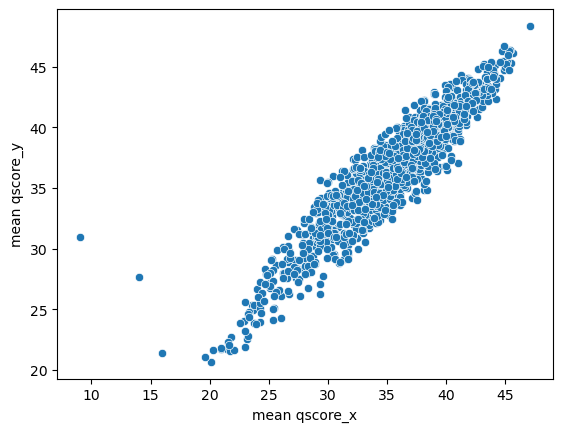

In [7]:
sns.scatterplot(data=mpiles, x='mean qscore_x', y='mean qscore_y')

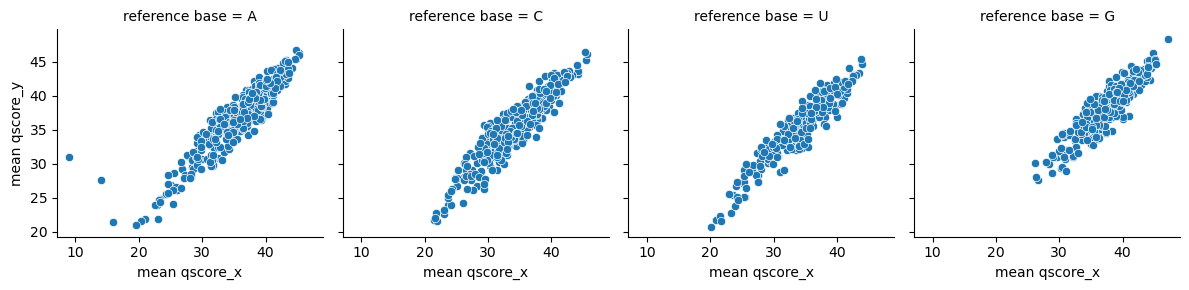

In [8]:
g = sns.FacetGrid(mpiles, col="reference base")
g.map(sns.scatterplot, 'mean qscore_x', 'mean qscore_y')

Let's do some t-tests and Mann–Whitney U tests to compare the two samples.

We can compare them by all bases or by bases.

In [14]:
pg.ttest(mpiles['mean qscore_x'], mpiles['mean qscore_y'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.464005,2440,two-sided,5.127163e-08,"[-1.49, -0.7]",0.22114,1.16e+05,0.999769


In [15]:
pg.ttest(mpiles['mean qscore_x'], mpiles['mean qscore_y'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-20.705948,1220,two-sided,7.369113e-82,"[-1.2, -0.99]",0.22114,1.338e+78,1.0


In [20]:
pttest = []
for i in mpiles['reference base'].unique():
    d = mpiles[mpiles['reference base']==i]
    t = pg.ttest(d['mean qscore_x'], d['mean qscore_y'], paired=True)
    t['base'] = i
    pttest.append(t)

In [22]:
pttest = pd.concat(pttest)
pttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,base
T-test,-10.694500,343,two-sided,3.147092e-23,"[-1.47, -1.01]",0.236007,1.147e+20,0.991914,A
T-test,-13.201234,346,two-sided,1.657134e-32,"[-1.44, -1.07]",0.258073,1.652e+29,0.997702,C
T-test,-10.365159,212,two-sided,1.252552e-20,"[-1.43, -0.97]",0.232376,3.544e+17,0.921619,U
T-test,-7.660702,316,two-sided,2.281832e-13,"[-0.87, -0.52]",0.183184,2.461e+10,0.901755,G


In [23]:
uttest = []
for i in mpiles['reference base'].unique():
    d = mpiles[mpiles['reference base']==i]
    t = pg.ttest(d['mean qscore_x'], d['mean qscore_y'])
    t['base'] = i
    uttest.append(t)
    
uttest = pd.concat(uttest)
uttest

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,base
T-test,-3.095198,686,two-sided,0.002047,"[-2.03, -0.45]",0.236007,9.016,0.870951,A
T-test,-3.399324,692,two-sided,0.000714,"[-1.98, -0.53]",0.258073,23.347,0.924305,C
T-test,-2.398093,424,two-sided,0.016912,"[-2.18, -0.22]",0.232376,1.71,0.667388,U
T-test,-2.306233,632,two-sided,0.021420,"[-1.29, -0.1]",0.183184,1.181,0.634122,G


They are statistically significant!

We will do a boxplot to visualise the two samples side-by-side. Before that we will merge the dataframes for the two samples and the reference sequence.

In [24]:
mp = pd.concat([bpile,cpile])
mp['position'] = mp[1] - 1
mp = pd.merge(ref, mp, on='position')

We can create a custom palette for plotting. The U+4SU sample (sample_C) has as higher Q score than control (sample_B).

Text(0, 0.5, 'Average Q-score')

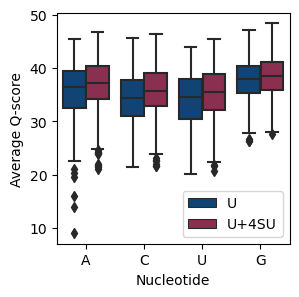

In [34]:
my_pal = {"U": "#004585", "U+4SU": "#99204B"}
# my_pal = {"U": "#060190", "U+4SU": "#B02318"}

plt.figure(figsize=(3,3))
g = sns.boxplot(data=mp, hue='sample', y='mean qscore', x='reference base', palette=my_pal)
sns.move_legend(g, "lower right")
g.legend_.set_title(None)
plt.xlabel('Nucleotide')
plt.ylabel('Average Q-score')

Text(0, 0.5, 'Average Q-score')

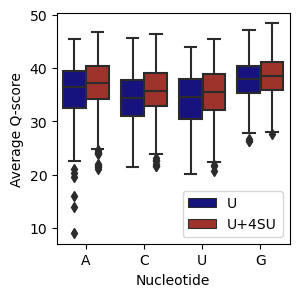

In [33]:
# my_pal = {"U": "#004585", "U+4SU": "#99204B"}
my_pal = {"U": "#0A00D7", "U+4SU": "#B02318"}

plt.figure(figsize=(3,3))
g = sns.boxplot(data=mp, hue='sample', y='mean qscore', x='reference base', palette=my_pal)
sns.move_legend(g, "lower right")
g.legend_.set_title(None)
plt.xlabel('Nucleotide')
plt.ylabel('Average Q-score')